## First Dense and CNN Baselines

In [246]:
#!pip install tensorflow_addons
from __future__ import print_function
import keras
import tensorflow as tf
from keras.datasets import mnist
from keras.models import Sequential, Model, Input
from keras.layers import Dense, Dropout, Flatten, SpatialDropout2D, SpatialDropout1D, AlphaDropout, LSTM
from keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, concatenate
from keras import backend as K
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tensorflow.keras.optimizers import Adam
from tensorflow_addons.optimizers import AdamW
from tensorflow.keras.losses import BinaryCrossentropy
import seaborn as sns

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from google.colab import files
import os

import matplotlib.pyplot as plt

plt.style.use("ggplot")
%matplotlib inline

### Model Composition Functions

### 1D Model

In [97]:
def compose_cnn_1d_model(input_shape_cnn: tuple = (246*245/2,), input_shape_rest: tuple = (3,), output_dim: int = 10,
                      act: str = "relu", opt = Adam(), loss = "binary_crossentropy") -> Sequential:
  
  #first input for connectivity matrix data
  first_input = Input(shape=input_shape_cnn)

  x = Conv1D(32, kernel_size=(3), activation=act)(first_input)
  x = MaxPooling1D(pool_size=(2))(x)

  x = Conv1D(16, kernel_size=(3), activation=act)(x)
  x = MaxPooling1D(pool_size=(4))(x)

  x = Conv1D(16, kernel_size=(3), activation=act)(x)
  #x = MaxPooling1D(pool_size=(4))(x)

  #x = Dropout(0.25)(x)
  x = Flatten()(x)
  #x = Dropout(0.25)(x)

  #second input for other data (age, sex, ...)
  #second_input = Input(shape=input_shape_rest)
  #merged = concatenate([flat, second_input])
  #x = Dropout(0.5)(merged)

  #dense part of the network
  x = Dense(32, activation=act)(x)
  x = Dropout(0.2)(x)
  x = Dense(16, activation=act)(x)
  x = Dropout(0.2)(x)
  out = Dense(output_dim, activation="sigmoid")(x)
  
  model = Model(inputs=[first_input], outputs=out)
  #model = Model(inputs=[first_input, second_input], outputs=out)
  model.compile(loss=loss,
                optimizer=opt, metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.FalseNegatives()])
  

  return model


### 2D Model

In [98]:
def compose_cnn_2d_model(input_shape_cnn: tuple = (246, 246), input_shape_rest: tuple = (3,), output_dim: int = 10,
                      act: str = "relu", opt = Adam(), loss = "binary_crossentropy") -> Sequential:
  
  #first input for connectivity matrix data
  first_input = Input(shape=input_shape_cnn)

  x = Conv2D(32, kernel_size=(3, 3), activation=act)(first_input)
  x = MaxPooling2D(pool_size=(2, 2))(x)

  x = Conv2D(16, kernel_size=(3, 3), activation=act)(x)
  x = MaxPooling2D(pool_size=(4, 4))(x)

  x = Conv2D(16, kernel_size=(3, 3), activation=act)(x)
  #x = MaxPooling2D(pool_size=(2))(x)

  #x = keras.layers.Dropout(0.25)(x)
  x = Flatten()(x)

  #second input for other data (age, sex, ...)
  #second_input = Input(shape=input_shape_rest)
  #merged = concatenate([flat, second_input])
  #x = Dropout(0.5)(x)

  #dense part of the network
  x = Dense(32, activation=act)(x)
  x = Dropout(0.2)(x)
  x = Dense(16, activation=act)(x)
  x = Dropout(0.2)(x)
  out = Dense(output_dim, activation="sigmoid")(x)
  
  model = Model(inputs=[first_input], outputs=out)
  #model = Model(inputs=[first_input, second_input], outputs=out)
  model.compile(loss=loss,
                optimizer=opt, metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.FalseNegatives()])
  

  return model


### Dense Model

In [99]:
def compose_dense_model(input_shape: tuple, output_dim: int = 10,
                      act: str = "relu", opt = Adam(), loss = "binary_crossentropy") -> Sequential:

  input = Input(shape=input_shape)
  x = Flatten()(input)
  #x = Dropout(0.1)(x)

  x = Dense(32, activation=act)(x)
  x = Dropout(0.2)(x)
  x = Dense(16, activation=act)(x)
  x = Dropout(0.2)(x)
  x = Dense(8, activation=act)(x)
  x = Dropout(0.2)(x)
  out = Dense(1, activation="sigmoid")(x)

  model = Model(inputs=[input], outputs=out)
  model.compile(loss=loss,
                optimizer=opt, metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.FalseNegatives()])
  

  return model


### Loading the Dataset

In [31]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

#load data from csv
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Innolab/test.csv")
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Innolab/train.csv")

Mounted at /content/drive


In [172]:
os.chdir("/content/drive/MyDrive/Colab Notebooks/Innolab")
import data_loader as dtl
import nn_modelling_utils as ut

<module 'nn_modelling_utils' from '/content/drive/MyDrive/Colab Notebooks/Innolab/nn_modelling_utils.py'>

### Preprocessing the Dataset and Creating Connectivity Matrices

In [33]:
y, X = dtl.preprocess_data(train)
y_test, X_test = dtl.preprocess_data(test)
y = np.array(y, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

In [34]:
n = len(X)
X = pd.concat([X, X_test])

In [35]:
#scale the data - ensure that X_train and X_test are scaled together
scaler = StandardScaler()
scaler.fit(X)
X[X.columns] = scaler.transform(X)

In [36]:
cols_to_drop = ["MEM_score", "Apoe"]
X.drop(columns=cols_to_drop, inplace = True)

In [37]:
non_conn_cols = ["age", "sex", "edyears"]
conn_info = X.drop(columns=non_conn_cols)
conn_info_test = conn_info.iloc[(n):, ]
conn_info = conn_info.iloc[:(n),]

In [38]:
X_test = X.iloc[(n):]
X = X.iloc[:(n)]

#### Creating Matrices from Flat Array

In [39]:
n_c = dtl.flat_to_mat(conn_info.iloc[0,:]).shape[0]
n_train = len(conn_info)
X_train_2d = np.zeros(n_train*n_c*n_c).reshape(n_train,n_c,n_c)

for i in range(n_train):
  X_train_2d[i] = dtl.flat_to_mat(conn_info.iloc[i,:])

In [40]:
n_test = len(X_test)
X_test_2d = np.zeros(n_test*n_c*n_c).reshape(n_test,n_c,n_c)

for i in range(n_test):
  X_test_2d[i] = dtl.flat_to_mat(conn_info_test.iloc[i,:])

In [41]:
X_train_2d_rest = np.zeros(3*n_train).reshape(n_train, 3)
X_train_2d_rest = np.array(X.iloc[:,:3])
X_train_2d_rest

array([[-1.41702664,  0.47199466, -0.37355769],
       [-0.59823819,  0.47199466, -0.37355769],
       [ 1.20309638,  0.47199466, -1.03484625],
       ...,
       [ 0.22055025, -1.15916335, -0.37355769],
       [-0.92575357,  0.47199466, -1.36549053],
       [ 1.03933869,  0.47199466, -0.37355769]])

In [42]:
X_train_1d = np.array(conn_info)
X_train_1d_rest = np.array(X[X.columns & non_conn_cols])
X_test_1d = np.array(conn_info_test)
X_test_1d_rest = np.array(X_test[X_test.columns & non_conn_cols])

In [43]:
y = y.reshape(n, 1)
y_test = y_test.reshape(len(y_test), 1)

[1.]


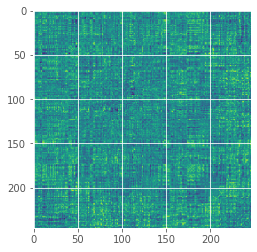

In [44]:
idx = 5
arr = X_train_2d[idx]
new_arr = ((arr - arr.min()) * (1/(arr.max() - arr.min()) * 255)).astype('uint8')
plt.imshow(new_arr.reshape(246,246))#, cmap='gray')
print(y[idx])

### Reducing the Dimensionality (PCA)

In [19]:
DIM_RED = False


In [20]:
if DIM_RED:
  pca = PCA(n_components=385)
  X_train_1d_pca = pca.fit_transform(X_train_1d.reshape(n, int(n_c*(n_c-1)/2)))

  n_comp = np.argmax(pca.explained_variance_ratio_.cumsum()>0.85)
  X_train_1d_pca = X_train_1d_pca[:,:(n_comp+1)]
  #X_train_1d_pca = X_train_1d_pca[:,:25]
  print(X_train_1d_pca.shape)
  X_train_1d = X_train_1d_pca

### Reshaping Data for CNNs

In [45]:
K.image_data_format()

'channels_last'

In [46]:
#reshaping the input
if K.image_data_format() == 'channels_first':
    X_train_2d = X_train_2d.reshape(X_train_2d.shape[0], 1, X_train_2d.shape[1], X_train_2d.shape[2])
    #X_test_2d = X_test_2d.reshape(X_test_2d.shape[0], 1, X_test_2d.shape[1], X_test_2d.shape[2])
    input_shape_2d = (1, X_train_2d.shape[1], X_train_2d.shape[2])
else:
    X_train_2d = X_train_2d.reshape(X_train_2d.shape[0], X_train_2d.shape[1], X_train_2d.shape[2], 1)
    #X_test_2d = X_test_2d.reshape(X_test_2d.shape[0], X_test_2d.shape[1], X_test_2d.shape[2], 1)
    input_shape_2d = (X_train_2d.shape[1], X_train_2d.shape[2], 1)

if K.image_data_format() == 'channels_first':
    X_train_1d = X_train_1d.reshape(X_train_1d.shape[0], 1, X_train_1d.shape[1])
    #X_test_1d = X_test_1d.reshape(X_test_1d.shape[0], 1, X_test_1d.shape[1], X_test_1d.shape[2])
    input_shape_1d = (1, X_train_1d.shape[1], X_train_1d.shape[2])
else:
    X_train_1d = X_train_1d.reshape(X_train_1d.shape[0], X_train_1d.shape[1], 1)
    #X_tests_1d = X_tests_1d.reshape(X_tests_1d.shape[0], X_tests_1d.shape[1], X_tests_1d.shape[2], 1)
    input_shape_1d = (X_train_1d.shape[1], 1)

In [47]:
print(input_shape_2d)
print(input_shape_1d)


(246, 246, 1)
(30135, 1)


In [48]:
X_train_2d.shape

(385, 246, 246, 1)

### Model Compiling and Hyperparameters

In [100]:
batch_size = 8
epochs = 30
opt = AdamW(weight_decay=0.001)#learning_rate=1e-07)
cnn_2d_model = compose_cnn_2d_model(input_shape_cnn=input_shape_2d, output_dim=1, opt=opt, act="relu")
cnn_1d_model = compose_cnn_1d_model(input_shape_cnn=input_shape_1d,  output_dim=1, opt=opt, act="relu")
dense_model = compose_dense_model(input_shape=input_shape_1d, output_dim=1, opt=opt, act="relu")

print(cnn_2d_model.summary())
print(cnn_1d_model.summary())
print(dense_model.summary())


Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 246, 246, 1)]     0         
                                                                 
 conv2d_24 (Conv2D)          (None, 244, 244, 32)      320       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 122, 122, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 120, 120, 16)      4624      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 30, 30, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 28, 28, 16)        232

#### To Do´s Modelle
- Val Dataset -> tracken während Optimierung
- Restliche Daten (3 Variablen einbinden)
- early stopping callback einbauen

In [138]:
train_1d = tf.data.Dataset.from_tensor_slices((X_train_1d, y))
test_1d = tf.data.Dataset.from_tensor_slices((X_test_1d, y_test))
train_2d = tf.data.Dataset.from_tensor_slices((X_train_2d, y))
test_2d = tf.data.Dataset.from_tensor_slices((X_test_2d, y_test))

SHUFFLE_BUFFER_SIZE = 100

train_1d_batch = train_1d.shuffle(SHUFFLE_BUFFER_SIZE).batch(batch_size)
test_1d_batch = test_1d.batch(batch_size)
train_2d_batch = train_2d.shuffle(SHUFFLE_BUFFER_SIZE).batch(batch_size)
test_2d_batch = test_2d.batch(batch_size)

In [101]:
cnn_2d_fit = cnn_2d_model.fit(train_2d_batch, epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/30
49/49 [==============================] - 24s 463ms/step - loss: 0.7148 - binary_accuracy: 0.5169 - false_negatives_6: 41.0000
Epoch 2/30
49/49 [==============================] - 20s 402ms/step - loss: 0.6926 - binary_accuracy: 0.5844 - false_negatives_6: 83.0000
Epoch 3/30
49/49 [==============================] - 20s 403ms/step - loss: 0.6782 - binary_accuracy: 0.5455 - false_negatives_6: 48.0000
Epoch 4/30
49/49 [==============================] - 20s 405ms/step - loss: 0.6782 - binary_accuracy: 0.5740 - false_negatives_6: 51.0000
Epoch 5/30
49/49 [==============================] - 20s 404ms/step - loss: 0.6591 - binary_accuracy: 0.5844 - false_negatives_6: 28.0000
Epoch 6/30
49/49 [==============================] - 20s 407ms/step - loss: 0.6326 - binary_accuracy: 0.6442 - false_negatives_6: 63.0000
Epoch 7/30
49/49 [==============================] - 20s 407ms/step - loss: 0.5940 - binary_accuracy: 0.6935 - false_negatives_6: 61.0000
Epoch 8/30
49/49 [=======================

In [115]:
def plot_history(fit, title: str = "") -> None:
  """
  """
  rescaled = []
  for i in fit.history.keys():
    if max(fit.history[i]) > 1:
      rescaled.append(i)
      plt.plot(np.array(fit.history[i])/np.max(fit.history[i]))
    else: 
      plt.plot(fit.history[i])

  plt.title(title)
  plt.ylabel('Scaled Metrics')
  plt.xlabel('Epoch')
  plt.legend( fit.history.keys(), loc='upper left')
  plt.show()
  print("rescaled features: ", rescaled)

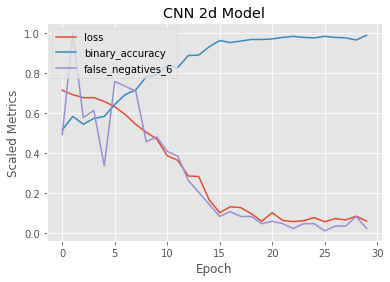

rescaled features:  ['false_negatives_6']


In [118]:
plot_history(cnn_2d_fit, "CNN 2d Model")

In [117]:
cnn_1d_fit = cnn_1d_model.fit(train_1d_batch, epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/30
49/49 [==============================] - 13s 232ms/step - loss: 0.7936 - binary_accuracy: 0.4987 - false_negatives_7: 138.0000
Epoch 2/30
49/49 [==============================] - 11s 229ms/step - loss: 0.6933 - binary_accuracy: 0.4909 - false_negatives_7: 53.0000
Epoch 3/30
49/49 [==============================] - 11s 233ms/step - loss: 0.6925 - binary_accuracy: 0.5299 - false_negatives_7: 0.0000e+00
Epoch 4/30
49/49 [==============================] - 11s 232ms/step - loss: 0.6921 - binary_accuracy: 0.5299 - false_negatives_7: 0.0000e+00
Epoch 5/30
49/49 [==============================] - 11s 230ms/step - loss: 0.6919 - binary_accuracy: 0.5299 - false_negatives_7: 0.0000e+00
Epoch 6/30
49/49 [==============================] - 11s 228ms/step - loss: 0.6916 - binary_accuracy: 0.5299 - false_negatives_7: 0.0000e+00
Epoch 7/30
49/49 [==============================] - 11s 228ms/step - loss: 0.6922 - binary_accuracy: 0.5299 - false_negatives_7: 0.0000e+00
Epoch 8/30
49/49 [=======

In [213]:
dense_fit = dense_model.fit(train_1d_batch, epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/30
49/49 [==============================] - 31s 12ms/step - loss: 4.9196 - binary_accuracy: 0.4935 - false_negatives_8: 130.0000
Epoch 2/30
49/49 [==============================] - 1s 14ms/step - loss: 1.4565 - binary_accuracy: 0.5481 - false_negatives_8: 63.0000
Epoch 3/30
49/49 [==============================] - 1s 12ms/step - loss: 0.8962 - binary_accuracy: 0.5558 - false_negatives_8: 27.0000
Epoch 4/30
49/49 [==============================] - 1s 12ms/step - loss: 0.7199 - binary_accuracy: 0.5818 - false_negatives_8: 20.0000
Epoch 5/30
49/49 [==============================] - 1s 12ms/step - loss: 0.7143 - binary_accuracy: 0.5455 - false_negatives_8: 27.0000
Epoch 6/30
49/49 [==============================] - 1s 12ms/step - loss: 0.7294 - binary_accuracy: 0.5688 - false_negatives_8: 20.0000
Epoch 7/30
49/49 [==============================] - 1s 16ms/step - loss: 0.6182 - binary_accuracy: 0.5974 - false_negatives_8: 12.0000
Epoch 8/30
49/49 [==============================] - 1

In [ ]:
pred = np.round(cnn_2d_model.predict(train_2d),2)
pred.shape
x = range(n)


f = plt.figure()
f.set_figwidth(16)
f.set_figheight(7)
plt.plot(x, abs(y - pred), linestyle="",marker="o", mfc = 'w')

In [129]:
metrics = cnn_2d_model.metrics_names
values = cnn_2d_model.evaluate(test_2d)
eval_cnn = dict(zip(metrics, values))


11/11 [==============================] - 1s 102ms/step - loss: 1.4855 - binary_accuracy: 0.6706 - false_negatives_6: 19.0000


### Comparison of the Models (Without MC Dropout Prediction)

In [ ]:
#print("dense model:\n", eval_dense, "\n")
#print("cnn model:\n", eval_cnn, "\n")

dense model:
 {'loss': 0.11308898031711578, 'accuracy': 0.9674999713897705} 

cnn model:
 {'loss': 0.03254108503460884, 'accuracy': 0.9902999997138977} 



### MC Predictions Comparison

In [146]:
mc_samples = 100

In [234]:
#to do: put into function 
cnn_2d_preds = ut.mc_predictions(X_test_2d, cnn_2d_model, mc_samples)
#accuracy for the whole ensemble
cnn_2d_pred_class = np.round(cnn_2d_preds.mean(axis=0))
cnn_2d_ens_acc = np.mean(cnn_2d_pred_class == y_test.flatten())
print(f"accuracy cnn 2d ensemble: {cnn_2d_ens_acc*100:10.2f}%")

accuracy cnn 2d ensemble:      67.06%


In [269]:
#accuracy for one dropout model
np.mean(np.round(np.array(cnn_2d_model(X_test_2d, training = True)).flatten()) == y_test.flatten())

0.6705882352941176

In [235]:
dense_preds = ut.mc_predictions(X_test_1d, dense_model, mc_samples)
#accuracy for the whole ensemble
dense_pred_class = np.round(dense_preds.mean(axis=0))
dense_ens_acc = np.mean(dense_pred_class == y_test.flatten())
print(f"accuracy dense ensemble (mean):{dense_ens_acc*100:.2f}%")

accuracy dense ensemble (mean):72.94%


In [228]:
#accuracy for one dropout model
np.mean(np.round(np.array(dense_model(X_test_1d, training = True)).flatten()) == y_test.flatten())

0.7411764705882353

In [239]:
idx = 1
mc_pred_proba = dense_preds.mean(axis=0)[idx]
mc_pred_std = dense_preds.std(axis=0)[idx]
print(mc_pred_proba, mc_pred_std, y_test.flatten()[idx])

0.08805115 0.12650701 0.0


In [240]:
np.where(y_test.flatten() != dense_pred_class)

(array([ 9, 19, 23, 28, 30, 35, 36, 39, 41, 45, 48, 52, 55, 58, 60, 64, 71,
        78, 79, 80, 81, 83, 84]),)

[1.]


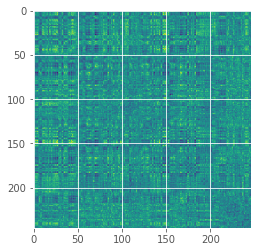

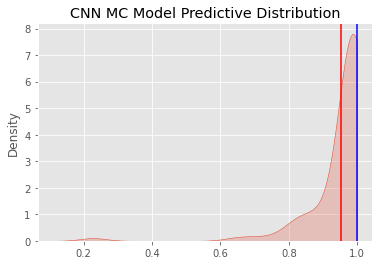

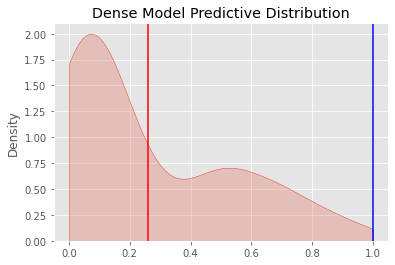

In [262]:
#to do: put into function 
idx = 84

print(y_test[idx])
plt.imshow(X_test_2d[idx])
plt.show()

sns.kdeplot(cnn_2d_preds[:,idx].flatten(), clip=(0.0, 1.0), shade=True).set_title("CNN MC Model Predictive Distribution")
plt.axvline(cnn_2d_preds[:,idx].mean(axis=0), color='red')
plt.axvline(y_test[idx], color='blue')
plt.show()

sns.kdeplot(dense_preds[:,idx], clip=(0.0, 1.0), shade=True).set_title("Dense Model Predictive Distribution")
plt.axvline(dense_preds[:,idx].mean(axis=0), color='red')
plt.axvline(y_test[idx], color='blue')
plt.show()

### Seperate MC Predictions vs Ensemble

##### CNN

In [274]:
#to do: put into function 
accs_cnn_2d = []
for i in range(mc_samples):
    mc_pred = cnn_2d_preds[i]
    acc = np.mean(y_test.flatten() == np.round(mc_pred))
    accs_cnn_2d.append(acc)
print(f"MC accuracy: {np.mean(accs_cnn_2d):.2%}")

MC accuracy: 66.71%


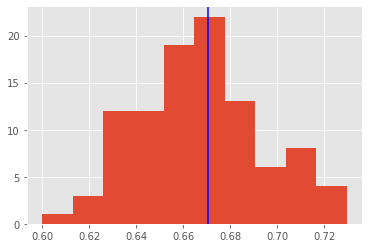

In [275]:
plt.hist(accs_cnn_2d);
plt.axvline(x=cnn_2d_ens_acc, color="b");

#### Dense

In [276]:
accs_dense = []
for i in range(mc_samples):
    mc_pred = dense_preds[i]
    acc = np.mean(y_test.flatten() == np.round(mc_pred))
    accs_dense.append(acc)
print(f"MC accuracy: {np.mean(accs_dense):.2%}")

MC accuracy: 73.00%


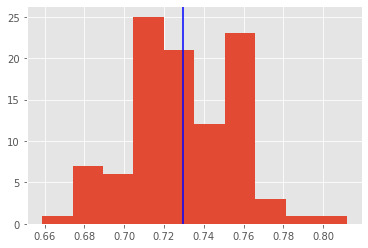

In [277]:
plt.hist(accs_dense);
plt.axvline(x=dense_ens_acc, color="b");

### Saving the Model

In [ ]:
!mkdir -p saved_model
cnn_1d_model.save('saved_model/my_model') 
#cnn_model.save(r"C:\Users\leosc\OneDrive\Desktop\WiSe 21-22\UQDL\applications")

INFO:tensorflow:Assets written to: saved_model/my_model/assets


The SavedModel format is a directory containing a protobuf binary and a TensorFlow checkpoint. Inspect the saved model directory:

In [ ]:
# my_model directory
!ls saved_model

# Contains an assets folder, saved_model.pb, and variables folder.
!ls saved_model/my_model

my_model
assets	keras_metadata.pb  saved_model.pb  variables


#### Loading the Model

In [ ]:
new_model = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 dropout_3 (Dropout)         (None, 12, 12, 64)        0         
                                                                 
 flatten_1 (Flatten)         (None, 9216)              0         
                                                                 
 dense_3 (Dense)             (None, 128)               1179776   
                                                      

#### Downloading the File as ZIP

In [ ]:
!zip -r /content/file.zip /content/saved_model

  adding: content/saved_model/ (stored 0%)
  adding: content/saved_model/my_model/ (stored 0%)
  adding: content/saved_model/my_model/variables/ (stored 0%)
  adding: content/saved_model/my_model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/saved_model/my_model/variables/variables.index (deflated 64%)
  adding: content/saved_model/my_model/keras_metadata.pb (deflated 90%)
  adding: content/saved_model/my_model/saved_model.pb (deflated 88%)
  adding: content/saved_model/my_model/assets/ (stored 0%)


In [ ]:
files.download("/content/file.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>